# Lab 2: Introduction to Itemset Mining in Python

In this lab, we will use a Groceries Dataset available on Kaggle. A full description of the dataset is available at https://www.kaggle.com/heeraldedhia/groceries-dataset. It is composed of 38,765 rows of items purchased at the grocery store and contains the following columns:
  * `Member_number` the id of the member who purchased the item
  * `Date` the date that the transaction occurred
  * `itemDescription` the item that was purchased


We will be performing Market Basket Analysis on the data by applying the **Apriori Algorithm**. When doing so, it is important to keep in mind that this is a very small, limited dataset so we must be careful with how we interpret the significance of any of our findings.

In [ ]:
#%pip install pandas
import pandas as pd
#%pip install numpy
import numpy as np
#%pip install seaborn
import seaborn as sns
%pip install apyori
from apyori import apriori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=06369d8fcd0bf25e1cd0ecb97654779142edbc464595181dfd3bd6c980b76809
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PREFIX = "drive/MyDrive/SI671-23FALL/Lab 2/"

Mounted at /content/drive


### 1. Data Exploration

Let's begin by loading the dataset and performing some preliminary data exploration.

In [ ]:
# load the dataset
groceries = pd.read_csv(GOOGLE_DRIVE_PREFIX + 'Groceries_dataset.csv')
print("Number of rows:", groceries.shape[0])
print("Number of columns:", groceries.shape[1])
groceries.sample(5)

Number of rows: 38765
Number of columns: 3


,Member_number,Date,itemDescription
29716,3750,30-09-2014,yogurt
23160,2849,24-11-2015,yogurt
33456,4132,02-12-2014,Instant food products
31777,2330,08-10-2014,sugar
33514,4577,22-06-2014,napkins


We see that we have 38,765 rows and three columns: the 'Member_number' (the ID of the customer), 'Date' (the date of the purchase) and 'itemDescription' (the product purchased). Therefore, each row represents an item that was purchased by a customer on a given date. If multiple items were purchased by the customer on that date, we will have multiple rows for that combination of 'Member_number' and 'Date'.

In [ ]:
# number of unique customers
print("Number of unique customers:", groceries.Member_number.nunique())
# number of unique items
print("Number of unique items:", groceries.itemDescription.nunique())

Number of unique customers: 3898
Number of unique items: 167


In [ ]:
# number of unique dates
print("Number of unique dates:", groceries.Date.nunique())
# range of dates
print("Date Range: {} - {}".format(groceries.Date.min(), groceries.Date.max()))

Number of unique dates: 728
Date Range: 01-01-2014 - 31-10-2015


In [ ]:
# number of unique customer-date combination
print("Number of unique customer-date combinations:",
      len(groceries.drop_duplicates(['Member_number', 'Date'])))

Number of unique customer-date combinations: 14963


Average Basket Size: 2.59 items
Minimum Basket Size: 2 items
Maximum Basket Size: 11 items


<ipython-input-30-5fc0ed9747cc>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False).set_title('Distribution of Basket Sizes');


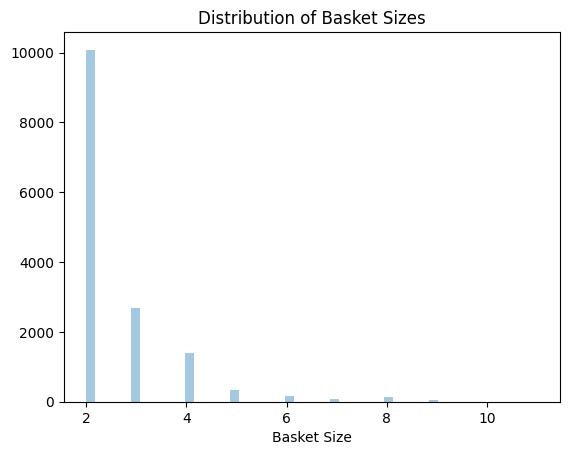

In [ ]:
# average size of basket
avg_basket_size = np.round(groceries.groupby(['Member_number', 'Date']).size().mean(), 2)
min_basket_size = np.round(groceries.groupby(['Member_number', 'Date']).size().min(), 2)
max_basket_size = np.round(groceries.groupby(['Member_number', 'Date']).size().max(), 2)
print("Average Basket Size: {} items".format(avg_basket_size))
print("Minimum Basket Size: {} items".format(min_basket_size))
print("Maximum Basket Size: {} items".format(max_basket_size))

# plot distribution of basket sizes
sizes = groceries.groupby(['Member_number', 'Date']).size().reset_index(name='Basket Size')['Basket Size']
sns.distplot(sizes, kde=False).set_title('Distribution of Basket Sizes');

It is similar to a geometric distribution.

In [ ]:
# what are the 10 most frequent items in the dataset? how many times were they bought?
groceries.itemDescription.value_counts()[:10]

whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: itemDescription, dtype: int64

### 2. Association Rules

Now that we have explored the nature of our data, we can start mining the data for insights. We will start with association rules. The end goal with association rules is to be able to predict other items that customers are likely to buy based on what they actually have bought/have in their basket. As we saw in lecture, an example of an association rule is that for people who bought {x, y, z}, they also tend to buy {v, w}. We will want to find all (interesting) rules X --> Y with minimum support and confidence. As a review:

  * `Support`: probability that a transaction contains X and Y
  * `Confidence`: conditional probability that a transaction having X also contains Y, P(Y|X)
  * `Interest`: difference between its confidence and the fraction of baskets that contain Y
  
Using a small subset of the data, we will first caclulate these concepts by hand. Then, we will apply the Apriori Algorithm to the entire dataset.

But first, we must do some data manipulation to get the data in the right format. We will need to group the data by 'Member_number' and 'Date' so that we have a set of the items for each transaction (i.e., all items purchased by the customer on that date).

In [ ]:
# get data in proper format
transactions = [set(items[1].itemDescription) for items in list(groceries.groupby(['Member_number','Date']))]
transactions[0] # example transaction

{'sausage', 'semi-finished bread', 'whole milk', 'yogurt'}

In [ ]:
# let's see what is items[0] in group by
member_number_date = [items[0] for items in list(groceries.groupby(['Member_number','Date']))]
member_number_date[0]

(1000, '15-03-2015')

In [ ]:
# we will use a subset of 4 transactions for this example

print("Transaction 1:", transactions[0])
print("Transaction 2:", transactions[6])
print("Transaction 3:", transactions[14])
print("Transaction 4:", transactions[58])

transaction_subset = [transactions[0], transactions[6], transactions[14], transactions[24]]

Transaction 1: {'yogurt', 'semi-finished bread', 'whole milk', 'sausage'}
Transaction 2: {'rolls/buns', 'whole milk', 'sausage'}
Transaction 3: {'rolls/buns', 'sausage'}
Transaction 4: {'yogurt', 'bottled beer', 'whole milk', 'sausage'}


In [ ]:
# we can also represent this data as a dataframe/matrix where 1 = item present and 0 = item absent

transactions_subset_df = pd.DataFrame({'semi-finished bread': [1,0,0,0],
                   'whole milk': [1,1,0,1],
                   'yogurt': [1,0,0,1],
                   'sausage': [1,1,1,1],
                   'rolls/buns': [0,1,1,0],
                   'bottled beer': [0,0,0,1] })

transactions_subset_df

,semi-finished bread,whole milk,yogurt,sausage,rolls/buns,bottled beer
0,1,1,1,1,0,0
1,0,1,0,1,1,0
2,0,0,0,1,1,0
3,0,1,1,1,0,1


### What if not hard-coded?

In [ ]:
from itertools import chain
transaction_ids = [0, 6, 14, 58]
transaction_subset = [transactions[id] for id in transaction_ids]
unique_items = set(chain(*transaction_subset))
binary_data = {item: [1 if item in transaction else 0 for transaction in transaction_subset] for item in unique_items}
transactions_subset_df2 = pd.DataFrame(binary_data)
transactions_subset_df2

,semi-finished bread,whole milk,yogurt,rolls/buns,sausage,bottled beer
0,1,1,1,0,1,0
1,0,1,0,1,1,0
2,0,0,0,1,1,0
3,0,1,1,0,1,1


In [ ]:
# calculate support for individual items: which are equal to or greater than minsup = 50%?

item_counter = {}
for product in transactions_subset_df.columns:
    item_counter[product] = sum(transactions_subset_df[product]>0)

item_counter

{'semi-finished bread': 1,
 'whole milk': 3,
 'yogurt': 2,
 'sausage': 4,
 'rolls/buns': 2,
 'bottled beer': 1}

Looking at the frequency of each individual item, we see that 'whole milk', and 'sausage' meet or surpass the 50% minsup threshold. Focusing in on these items, let's see if there are any pairs of items that surpass the 50% minsup threshold as well.

Here is the **absolute support**

In [ ]:
# calculate support for item pairs: which are equal to or greater than minsup = 50%?

# source: https://dzenanhamzic.com/2017/01/19/market-basket-analysis-mining-frequent-pairs-in-python/

# take data matrix from dataframe
transaction_matrix = transactions_subset_df.to_numpy()
# get number of rows and columns
rows, columns = transaction_matrix.shape
# init new matrix
frequent_items_matrix = np.zeros((6,6))
# compare every product with every other
for this_column in range(0, columns-1):
    for next_column in range(this_column + 1, columns):
        # multiply product pair vectors
        product_vector = transaction_matrix[:,this_column] * transaction_matrix[:,next_column]
        # check the number of pair occurrences in baskets
        count_matches = sum((product_vector)>0)
        # save values to new matrix
        frequent_items_matrix[this_column,next_column] = count_matches

frequent_items_df = pd.DataFrame(frequent_items_matrix, columns = transactions_subset_df.columns.values, index = transactions_subset_df.columns.values)
frequent_items_df

,semi-finished bread,whole milk,yogurt,sausage,rolls/buns,bottled beer
semi-finished bread,0.0,1.0,1.0,1.0,0.0,0.0
whole milk,0.0,0.0,2.0,3.0,1.0,1.0
yogurt,0.0,0.0,0.0,2.0,0.0,1.0
sausage,0.0,0.0,0.0,0.0,2.0,1.0
rolls/buns,0.0,0.0,0.0,0.0,0.0,0.0
bottled beer,0.0,0.0,0.0,0.0,0.0,0.0


Looking at the results, we see that the only itemset that surpasses our 50% minsup threshold is {whole milk, sausage}. Now let's calculate the confidence to see if it surpasses our 50% minconf threshold as well.

Association rule 1: sausage -> whole milk

Confidence = Pr(whole milk | sausage) = 3/4 = 75%

Interest = conf(sausage -> whole milk) − Pr(whole milk) = 75% - 75% = 0% (definitely not interesting)


Association rule 2: whole milk -> sausage

Confidence = Pr(sausage | whole milk) = 3/3 = 100%

Interest = conf(whole milk → sausage) − Pr(sausage) = 100% - 100% = 0% (also definitely not interesting)


This serves an an important lesson that **not all high confidence association rules are interesting!** Next, let's apply the apriori algorithm to our entire dataset to see if we can find more interesting insights.

### 2.1 Association Rules using the Apriori Algorithm

With these concepts in mind, we can specify the min_support and min_confidence when using the Apriori Algorithm. Also, we can specify the value for min_lift, a measure of interestingness. Keep in mind that we will want to try out different values of min_support, min_confidence and min_lift depending on the task and problem at hand - it will require a bit of trial and error.

In [ ]:
association_results = list(apriori(transactions, min_support = 0.003, min_confidence = 0.05, min_lift=1.0))
association_results = filter(lambda x: len(x.items) > 1, association_results) # filtering to rules with at least 2 items

# source: https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/
for item in association_results:
    items = [x for x in item.items]
    print("Rule: " + items[0] + " -> " + items[1])
    print("Support: " + str(item[1]))
    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: bottled beer -> sausage
Support: 0.003341575887188398
Confidence: 0.07374631268436578
Lift: 1.2220000849348451
Rule: yogurt -> citrus fruit
Support: 0.004611374724319989
Confidence: 0.08679245283018867
Lift: 1.0106423904265471
Rule: other vegetables -> frankfurter
Support: 0.005146026866270133
Confidence: 0.13628318584070798
Lift: 1.1161495948191098
Rule: rolls/buns -> fruit/vegetable juice
Support: 0.003742564993651006
Confidence: 0.11001964636542241
Lift: 1.0001360683874942
Rule: pastry -> sausage
Support: 0.003207912851700862
Confidence: 0.06201550387596899
Lift: 1.0276168156103256
Rule: shopping bags -> root vegetables
Support: 0.003341575887188398
Confidence: 0.0702247191011236
Lift: 1.0093875810856026
Rule: soda -> sausage
Support: 0.005948005079195348
Confidence: 0.09856035437430785
Lift: 1.0149749363405152
Rule: yogurt -> sausage
Support: 0.005747510525964045
Confidence: 0.09523809523809523
Lift: 1.1089864739670185


Using the given criteria, we get a set of 8 association rules. We can see how some may be interesting. For example, we may predict that those who are buying bottled beer will also buy sausages since they could be planning a barbecue/party.

### 3. Frequent Itemsets

Next, let's experiment with Finding Frequent Itemsets. We want to find items that are frequently purchased together in our groceries data. To do so, we must set a value for min_support, the minimum support needed for the itemset to be considered frequent. As a reminder, support refers to the fraction of baskets that contain the itemset. Therefore, an itemset will be considered frequent if its support value is greater than or equal to the min_support threshold we set.

In [ ]:
itemsets = list(apriori(transactions, min_support=0.05)) # setting the minimum support value to 0.05
frequent_itemsets = []

for item in itemsets:
    frequent_itemsets.append((item.items, item.support))

sorted_freq_itemsets = sorted(frequent_itemsets, key= lambda t:t[1], reverse=True)

pd.DataFrame(sorted_freq_itemsets, columns=['Items', 'Support'])

,Items,Support
0,(whole milk),0.157923
1,(other vegetables),0.122101
2,(rolls/buns),0.110005
3,(soda),0.097106
4,(yogurt),0.085879
5,(root vegetables),0.069572
6,(tropical fruit),0.067767
7,(bottled water),0.060683
8,(sausage),0.060349
9,(citrus fruit),0.053131


We see that all of our itemsets only include 1 item... this is not very interesting to us since we want to know what items customers tend to buy together. Let's up the value of min_support so that we get results with 2 or more items and then filter the itemsets to those with at least 2 items in them.

In [ ]:
itemsets = list(apriori(transactions, min_support=0.007))
itemsets = filter(lambda x: len(x.items) > 1, itemsets)

frequent_itemsets = []
for item in itemsets:
    frequent_itemsets.append((item.items, item.support))

sorted_freq_itemsets = sorted(frequent_itemsets, key= lambda t:t[1], reverse=True)

pd.DataFrame(sorted_freq_itemsets, columns=['Items', 'Support'])

,Items,Support
0,"(other vegetables, whole milk)",0.014837
1,"(rolls/buns, whole milk)",0.013968
2,"(soda, whole milk)",0.011629
3,"(yogurt, whole milk)",0.011161
4,"(rolls/buns, other vegetables)",0.010559
5,"(other vegetables, soda)",0.009691
6,"(whole milk, sausage)",0.008955
7,"(tropical fruit, whole milk)",0.008220
8,"(yogurt, other vegetables)",0.008087
9,"(rolls/buns, soda)",0.008087


### 4. Evaluation of Frequent Itemsets

There are a variety of metrics available for evaluating frequent itemsets. Applying evaluation metrics is an important task since not all frequent itemsets will be meaningful. One example is Jaccard Similarity, which we will employ here. The entirety of the task is the following:
  * Split the dataset into seasons (Fall, Winter, Spring, Summer) and select 2 of your choice
  * Identify the 25 most frequent itemsets (with at least 2 items in each itemset) for each season
  * Compute the Jaccard Similarity between them

In [ ]:
### YOUR CODE: divide the groceries dataframe into 4 dataframes, one for each season
### then, select 2 of them to use for the remainder of this analysis

### you can use the following breakdown of months into seasons:
# Winter = December (12), January (01), February (02)
# Spring = March (03), April (04), May (05)
# Summer = June (06), July (07), August (08)
# Fall = September (09), October (10), November (11)



In [ ]:
### YOUR CODE: transform the data into the proper format


In [ ]:
### YOUR CODE: find the top 25 most frequent itemsets (with at least 2 items) for each season
### sort them by their value for 'support' to identify the top 25 itemsets
### HINT: adjust the value of min_support, as necessary



In [ ]:
### YOUR CODE: compute the Jaccard Similarity between the two sets of the top 25 most frequent itemsets



In [ ]:
# function to split dates into seasons based on the month
def Season(date):
    mm = date.split("-")[1]
    season = ''
    if mm in ['12', '01', '02']:
        season = 'Winter'
    elif mm in ['03', '04', '05']:
        season = 'Spring'
    elif mm in ['06', '07', '08']:
        season = 'Summer'
    elif mm in ['09', '10', '11']:
        season = 'Fall'
    return season

groceries['Season'] = groceries.Date.apply(Season) # apply the function
# create the season dataframes
groceries_winter = groceries[groceries.Season == 'Winter']
groceries_fall = groceries[groceries.Season == 'Fall']
groceries_spring = groceries[groceries.Season == 'Spring']
groceries_summer = groceries[groceries.Season == 'Summer']

# check
groceries_winter.shape[0] + groceries_fall.shape[0] + groceries_spring.shape[0] + groceries_summer.shape[0]

38765

In [ ]:
transactions_summer = [set(items[1].itemDescription) for items in
                                           list(groceries_summer.groupby(['Member_number','Date']))]
transactions_winter = [set(items[1].itemDescription) for items in
                                           list(groceries_winter.groupby(['Member_number','Date']))]

In [ ]:
# summer
itemsets_summer = list(apriori(transactions_summer, min_support=0.005))
itemsets_summer = filter(lambda x: len(x.items) > 1, itemsets_summer)

frequent_itemsets_summer = []
for item in itemsets_summer:
    frequent_itemsets_summer.append((item.items, item.support))

sorted_freq_itemsets_summer = sorted(frequent_itemsets_summer, key= lambda t:t[1], reverse=True)[0:25]

# winter
itemsets_winter = list(apriori(transactions_winter, min_support=0.005))
itemsets_winter = filter(lambda x: len(x.items) > 1, itemsets_winter)

frequent_itemsets_winter = []
for item in itemsets_winter:
    frequent_itemsets_winter.append((item.items, item.support))

sorted_freq_itemsets_winter = sorted(frequent_itemsets_winter, key= lambda t:t[1], reverse=True)[0:25]

In [ ]:
sorted_freq_itemsets_summer

[(frozenset({'other vegetables', 'whole milk'}), 0.015100234313980734),
 (frozenset({'soda', 'whole milk'}), 0.013017443374121323),
 (frozenset({'rolls/buns', 'whole milk'}), 0.01249674563915647),
 (frozenset({'other vegetables', 'rolls/buns'}), 0.011195001301744337),
 (frozenset({'whole milk', 'yogurt'}), 0.01093465243426191),
 (frozenset({'other vegetables', 'soda'}), 0.009632908096849779),
 (frozenset({'other vegetables', 'yogurt'}), 0.009112210361884926),
 (frozenset({'domestic eggs', 'whole milk'}), 0.008591512626920072),
 (frozenset({'rolls/buns', 'yogurt'}), 0.008591512626920072),
 (frozenset({'root vegetables', 'whole milk'}), 0.008331163759437647),
 (frozenset({'sausage', 'whole milk'}), 0.008331163759437647),
 (frozenset({'rolls/buns', 'soda'}), 0.00807081489195522),
 (frozenset({'other vegetables', 'sausage'}), 0.007810466024472794),
 (frozenset({'bottled beer', 'whole milk'}), 0.007550117156990367),
 (frozenset({'pastry', 'whole milk'}), 0.007550117156990367),
 (frozenset({

In [ ]:
sorted_freq_itemsets_winter

[(frozenset({'other vegetables', 'whole milk'}), 0.012869660460021906),
 (frozenset({'other vegetables', 'rolls/buns'}), 0.011226725082146768),
 (frozenset({'rolls/buns', 'whole milk'}), 0.01095290251916758),
 (frozenset({'soda', 'whole milk'}), 0.01067907995618839),
 (frozenset({'tropical fruit', 'whole milk'}), 0.009309967141292442),
 (frozenset({'whole milk', 'yogurt'}), 0.009309967141292442),
 (frozenset({'other vegetables', 'yogurt'}), 0.008488499452354874),
 (frozenset({'other vegetables', 'soda'}), 0.008214676889375685),
 (frozenset({'rolls/buns', 'soda'}), 0.007667031763417305),
 (frozenset({'root vegetables', 'whole milk'}), 0.007119386637458927),
 (frozenset({'sausage', 'whole milk'}), 0.007119386637458927),
 (frozenset({'rolls/buns', 'yogurt'}), 0.006845564074479737),
 (frozenset({'pip fruit', 'whole milk'}), 0.0065717415115005475),
 (frozenset({'bottled beer', 'whole milk'}), 0.006024096385542169),
 (frozenset({'bottled water', 'whole milk'}), 0.006024096385542169),
 (froze

In [ ]:
itemsets_summer = set(item[0] for item in sorted_freq_itemsets_summer)
itemsets_winter = set(item[0] for item in sorted_freq_itemsets_winter)
intersection = len(itemsets_summer.intersection(itemsets_winter))
union = len(itemsets_summer.union(itemsets_winter))
similarity = intersection/union

print("Intersection: {}; Union: {}; Jaccard Similarity: {}".format(intersection, union, similarity))

Intersection: 19; Union: 31; Jaccard Similarity: 0.6129032258064516


In this example, we see that among the top 25 most frequent itemsets for the transactions for summer and winter, there are 19 in common resulting in a Jaccard Similarity of 0.613. This indicates that there is substantial overlap in the itemsets purchased in summer and winter but there are some differences. If we wanted to dive deeper into this, we could take a look at the itemsets that are the same between summer and winter versus those that are different to try and gain insights.